<a href="https://colab.research.google.com/github/Jaesu26/Dacon-Basic/blob/main/%EC%87%BC%ED%95%91%EB%AA%B0%ED%8F%89%EC%A0%90-%EB%B6%84%EB%A5%98-BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 쇼핑몰 리뷰 평점 분류 경진대회

## 데이터 불러오기

- 참고

1. https://complexoftaste.tistory.com/2

2. https://github.com/SKTBrain/KoBERT/blob/master/scripts/NSMC/naver_review_classifications_pytorch_kobert.ipynb

In [1]:
import numpy as np
import pandas as pd
import os, re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from glob import glob

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive

drive.mount('/content/drive') ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [6]:
# !pip install mxnet
# !pip install gluonnlp
# !pip install sentencepiece==0.1.91
# !pip install transformers==4.8.2
# !pip install torch

In [127]:
## Hugging Face를 통한 토크나이저 로드
# !pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [90]:
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 2  ## 에폭이 2일 때 valid accuracy가 가장 높았다
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5
seed = 22

In [10]:
%cd  '/content/drive/MyDrive/Colab Notebooks/쇼핑몰-평점-분류'

/content/drive/MyDrive/Colab Notebooks/쇼핑몰-평점


In [11]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [12]:
df.head()

,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


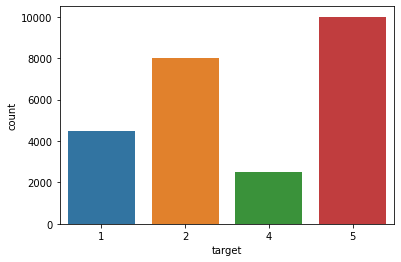

In [13]:
sns.countplot(data=df, x='target')

## 데이터 셋 및 딥러닝 모델 정의

In [14]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import gluonnlp as nlp
from tqdm import tqdm, tqdm_notebook
import gc

## kobert
from kobert_tokenizer import KoBERTTokenizer

## transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel, DistilBertModel

In [15]:
device = torch.device('cuda:0')

In [16]:
def seed_everything(seed: int = 22):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [74]:
seed_everything(seed) ## 재현을 위한 seed 고정

In [18]:
df['target'] = df['target'].map({1:0, 2:1, 4:2, 5:3})

In [19]:
target = df['target']

In [75]:
def get_dataset(df):
    data_list = []
    for review, label in zip(df['reviews'], df['target'])  :
        data = [review, label]   
        data_list.append(data)
    return data_list

In [76]:
dataset = get_dataset(df)

In [91]:
## BERT 모델, Vocabulary 불러오기
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

In [78]:
class BERTDataset(Dataset):
  
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [92]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_valid = train_test_split(dataset, test_size=0.2, shuffle=True, stratify=target, random_state=seed)

In [93]:
tok = tokenizer.tokenize
data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_valid = BERTDataset(dataset_valid, 0, 1, tok, vocab, max_len, True, False)

In [94]:
train_dataloader = DataLoader(data_train, batch_size=batch_size)
valid_dataloader = DataLoader(data_valid, batch_size=batch_size)

In [82]:
class BERTClassifier(nn.Module):
  
    def __init__(self,
                 bert,
                 hidden_size=768,
                 num_classes=4, ## 클래스 수 조정
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

## 모델 학습

In [83]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy() / max_indices.size()[0]
    return train_acc

In [95]:
## BERT 모델 불러오기
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

## optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay':0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [96]:
seed_everything(seed) ## 재현을 위한 seed 고정
for e in range(num_epochs):
    gc.collect()
    torch.cuda.empty_cache()

    train_acc = 0.0
    valid_acc = 0.0

    ## 모델 학습
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step() 

        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print('epoch {} batch id {} loss {} train acc {}'.format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print('epoch {} train acc {}'.format(e+1, train_acc / (batch_id+1)))
    
    ## 모델 평가
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        valid_acc += calc_accuracy(out, label)
    print('epoch {} valid acc {}'.format(e+1, valid_acc / (batch_id+1)))

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.4395232200622559 train acc 0.15625
epoch 1 batch id 201 loss 0.8589274287223816 train acc 0.5796019900497512
epoch 1 train acc 0.6102735623003195


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 1 valid acc 0.6720727848101266


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.8824954032897949 train acc 0.625
epoch 2 batch id 201 loss 0.7854078412055969 train acc 0.7014148009950248
epoch 2 train acc 0.7079173322683706


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 2 valid acc 0.6863132911392406


## test 예측

In [120]:
## train에서 사용한 tok, max_len, batch_size, device를 그대로 입력 (전역변수로 사용함)
def predict(reviews):
    review_list = []  
    pred_list = []  
    for review in reviews: 
        review_list.append([review, -1]) ## 데이터 셋이 요구하는 input으로 만들기 위해 임의의 라벨을 추가함
      
    pdData = pd.DataFrame(review_list, columns = [['reviews', 'target']] )
    pdData = pdData.values
    test_set = BERTDataset(pdData, 0, 1, tok, vocab, max_len, True, False) 
    test_input = DataLoader(test_set, batch_size=batch_size)
    
    for batch_id, (token_ids, test_length, target_ids, label) in enumerate(tqdm_notebook(test_input)):
        token_ids = token_ids.long().to(device)
        test_length = test_length
        target_ids = target_ids.long().to(device)

        ## 예측
        model.eval()
        preds = model(token_ids, test_length, target_ids)
      
        for pred in preds:
            label = torch.argmax(pred)
            label = label.cpu().data.item()
            pred_list.append(label)

    return pred_list  

In [121]:
preds = predict(test['reviews'])

  0%|          | 0/391 [00:00<?, ?it/s]

In [123]:
submission['target'] = preds
submission['target'] = submission['target'].map({0:1, 1:2, 2:4, 3:5})

In [124]:
submission.head()

,id,target
0,0,2
1,1,1
2,2,5
3,3,1
4,4,1


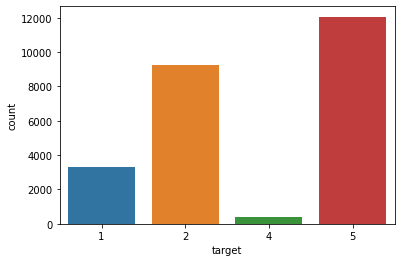

In [125]:
sns.countplot(data=submission, x='target')

In [126]:
submission.to_csv('./Data/submission_kobert.csv', index=False)